# MLBD : Project on the music dataset

The base subject is : Predicting a playlist that satisfies group members (e.g., to decide the music to play in a party). By playlist we mean a set of songs that can be from the same artist or multiple ones.

Research questions : 
- How do we compute the metrics for similarity between user ?
- What is the impact of the number of plays ?
- What is the impact of the gender, age and country on the kind of music people are listening to ?
- Not a question : Use the Spotify API to access to the genre, maybe. (using Spotipy)
- See what we can get from the Spotify API !
- Can we generate a music playlist for multiple users based on what they listened?

### 1. Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### 2. Load the data

In [2]:
DATA_FOLDER = 'data/'
TOP_FOLDER = DATA_FOLDER + 'lastfm-dataset-360k/'
TIMELINE_FOLDER = DATA_FOLDER + 'lastfm-dataset-1k/'

top_user = pd.read_csv(TOP_FOLDER + 'usersha1-profile.tsv', sep = '\t', error_bad_lines = False, header = None)
top_data = pd.read_csv(TOP_FOLDER + 'usersha1-artmbid-artname-plays.tsv', sep = '\t', error_bad_lines = False, header = None)

timeline_user = pd.read_csv(TIMELINE_FOLDER + 'userid-profile.tsv', sep = '\t', error_bad_lines = False, header = 0)
timeline_data = pd.read_csv(TIMELINE_FOLDER + 'userid-timestamp-artid-artname-traid-traname.tsv', sep = '\t', error_bad_lines = False, header = None)

b'Skipping line 2120260: expected 6 fields, saw 8\n'
b'Skipping line 2446318: expected 6 fields, saw 8\n'
b'Skipping line 11141081: expected 6 fields, saw 8\n'
b'Skipping line 11152099: expected 6 fields, saw 12\nSkipping line 11152402: expected 6 fields, saw 8\n'
b'Skipping line 11882087: expected 6 fields, saw 8\n'
b'Skipping line 12902539: expected 6 fields, saw 8\nSkipping line 12935044: expected 6 fields, saw 8\n'
b'Skipping line 17589539: expected 6 fields, saw 8\n'


# EDA

In [3]:
top_user.rename(columns = {0 : 'ID', 1 : 'Gender', 2 : 'Age', 3 : 'Country', 4 : 'Registered'}, inplace = True)
top_data.rename(columns = {0 : 'ID', 1 : 'Artist_ID', 2 : 'Artist', 3 : 'Plays'}, inplace = True)
timeline_user.rename(columns = {'#id' : 'ID', 'gender' : 'Gender', 'age' : 'Age', 'country' : 'Country', 'registered' : 'Registered'}, inplace = True)
timeline_data.rename(columns = {0 : 'ID', 1 : 'Timestamp', 2 : 'Artist_ID', 3 : 'Artist', 4 : 'Track_ID', 5 : 'Track'}, inplace = True)

In [4]:
# we'll check the number of NaNs for each dataset
print(top_user.isna().sum(), '\n')
print(top_data.isna().sum(), '\n')
print(timeline_user.isna().sum(), '\n')
print(timeline_data.isna().sum())

ID                0
Gender        32775
Age           74900
Country           0
Registered        0
dtype: int64 

ID                0
Artist_ID    226137
Artist          204
Plays             0
dtype: int64 

ID              0
Gender        108
Age           706
Country        85
Registered      8
dtype: int64 

ID                 0
Timestamp          0
Artist_ID     600848
Artist             0
Track_ID     2162719
Track             12
dtype: int64


In [5]:
print(top_user.shape)
top_user.head(3)

(359347, 5)


,ID,Gender,Age,Country,Registered
0,00000c289a1829a808ac09c00daf10bc3c4e223b,f,22.0,Germany,"Feb 1, 2007"
1,00001411dc427966b17297bf4d69e7e193135d89,f,NaN,Canada,"Dec 4, 2007"
2,00004d2ac9316e22dc007ab2243d6fcb239e707d,NaN,NaN,Germany,"Sep 1, 2006"


In [6]:
print(top_data.shape)
top_data.head(3)

(17535655, 4)


,ID,Artist_ID,Artist,Plays
0,00000c289a1829a808ac09c00daf10bc3c4e223b,3bd73256-3905-4f3a-97e2-8b341527f805,betty blowtorch,2137
1,00000c289a1829a808ac09c00daf10bc3c4e223b,f2fb0ff0-5679-42ec-a55c-15109ce6e320,die Ärzte,1099
2,00000c289a1829a808ac09c00daf10bc3c4e223b,b3ae82c2-e60b-4551-a76d-6620f1b456aa,melissa etheridge,897


In [7]:
top_merged = top_data.merge(top_user, left_on='ID', right_on='ID')
top_merged = top_merged.drop(columns=['Artist_ID', 'Registered'])
top_merged = top_merged.drop(top_merged[top_merged.isna().any(axis = 1)].index)

In [8]:
# !!! it seems that we lose aproximetely 100k users by merging two datasets above. 
# But I guess we can't do anything with that, but probably it's good to mention it in eda ~rap

# We decide to eliminate users, which have less than 6 favourite artists (as per Aleandro's advice)
top_merged_IDs = top_merged.groupby(['ID']).size().reset_index()
users_id = top_merged_IDs[top_merged_IDs[0] > 5]['ID']
top_merged = top_merged[top_merged['ID'].isin(users_id)]

In [9]:
# we have almost 300k artists
top = top_merged.groupby(['Artist', 'Plays']).size().reset_index()
# we check how many times an artist occurs in dataset
artists_occ = top.groupby('Artist').size().sort_values(ascending = True).reset_index(name = 'Sum of occurances')
artists_occ

,Artist,Sum of occurances
0,04)],1
1,john p kee,1
2,john o’callaghan ft. jaren,1
3,john oneil,1
4,john olav nilsen,1
...,...,...
249789,metallica,2567
249790,pink floyd,2568
249791,nine inch nails,2600
249792,radiohead,2979


In [10]:
# to reduce the dataset, we'll drop artists who were listened only by less than x users
top_artists = artists_occ[artists_occ['Sum of occurances'] > 1000]['Artist']
top_merged = top_merged.loc[top_merged['Artist'].isin(top_artists)].reset_index().drop(columns = ['index'])

In [12]:
top_merged = top_merged.drop(columns=['ID'])
columns_merged = ['Artist', 'Gender', 'Country']

for col in columns_merged:
    top_merged = top_merged.replace(to_replace=top_merged[col].unique(), value=np.arange(top_merged[col].unique().shape[0]))
top_merged = top_merged.astype('int32')

In [13]:
normalized_top_merged = (top_merged - top_merged.mean()) / top_merged.std()
normalized_top_merged.corr()

,Artist,Plays,Gender,Age,Country
Artist,1.000000,-0.002203,-0.014845,-0.007306,-0.011223
Plays,-0.002203,1.000000,0.029597,-0.010733,-0.010402
Gender,-0.014845,0.029597,1.000000,0.054026,-0.002794
Age,-0.007306,-0.010733,0.054026,1.000000,-0.006493
Country,-0.011223,-0.010402,-0.002794,-0.006493,1.000000


In [14]:
print(timeline_user.shape)
timeline_user.head(3)

(992, 5)


,ID,Gender,Age,Country,Registered
0,user_000001,m,NaN,Japan,"Aug 13, 2006"
1,user_000002,f,NaN,Peru,"Feb 24, 2006"
2,user_000003,m,22.0,United States,"Oct 30, 2005"


In [15]:
print(timeline_data.shape)
timeline_data.head(3)

(19098853, 6)


,ID,Timestamp,Artist_ID,Artist,Track_ID,Track
0,user_000001,2009-05-04T23:08:57Z,f1b1cf71-bd35-4e99-8624-24a6e15f133a,Deep Dish,NaN,Fuck Me Im Famous (Pacha Ibiza)-09-28-2007
1,user_000001,2009-05-04T13:54:10Z,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,坂本龍一,NaN,Composition 0919 (Live_2009_4_15)
2,user_000001,2009-05-04T13:52:04Z,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,坂本龍一,NaN,Mc2 (Live_2009_4_15)


In [16]:
timeline_merged = timeline_data.merge(timeline_user, left_on = 'ID', right_on= 'ID')
timeline_merged = timeline_merged.drop(columns = ['Artist_ID', 'Track_ID'])
timeline_merged = timeline_merged.drop(timeline_merged[timeline_merged.isna().any(axis = 1)].index)
timeline_merged.head(3)

,ID,Timestamp,Artist,Track,Gender,Age,Country,Registered
74123,user_000003,2009-05-04T10:29:04Z,Samuli Kemppi,Samuli Kemppi - January 2009,m,22.0,United States,"Oct 30, 2005"
74124,user_000003,2009-04-21T16:56:35Z,Dirt Nasty,True Hollywood Story,m,22.0,United States,"Oct 30, 2005"
74125,user_000003,2009-04-21T16:47:11Z,Dirt Nasty,Gotta Leave This Town,m,22.0,United States,"Oct 30, 2005"


### 3. Analysis

In [17]:
max_track = timeline_data.groupby(['ID', 'Track', 'Artist']).count()['Timestamp'].sort_values().groupby(level = 0).tail(1)

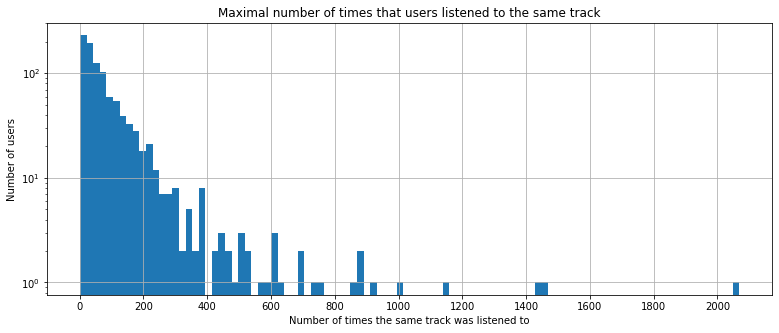

In [18]:
max_track.reset_index().hist(bins = 100, figsize = (13, 5))
plt.yscale('log')
plt.title('Maximal number of times that users listened to the same track')
plt.xlabel('Number of times the same track was listened to')
plt.ylabel('Number of users')
_ = plt.xticks(range(0, 2200, 200))

We can observe that most people did not listen to the same song for more than 200 times, with a big chunk of it found under 100.

In [19]:
max_top = top_data.groupby(['ID'])['Plays'].max()

Text(0, 0.5, 'Number of users')

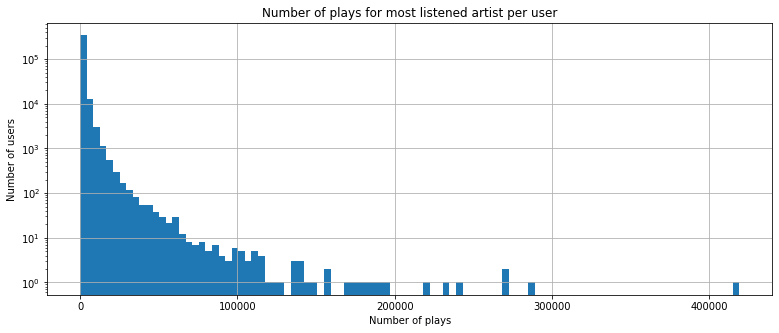

In [20]:
max_top.reset_index().hist(bins = 100, figsize = (13, 5))
plt.yscale('log')
plt.title('Number of plays for most listened artist per user')
plt.xlabel('Number of plays')
plt.ylabel('Number of users')

In [21]:
top_data['Plays'].max()

419157

In [22]:
top_data[top_data['Plays'] == 419157]

,ID,Artist_ID,Artist,Plays
9654928,8d0384537845e7f2b1b8b3e8a9f67eb8d9439794,dcaa4f81-bfb7-44eb-8594-4e74f004b6e4,nofx,419157


In [23]:
top_user[top_user['ID'] == '8d0384537845e7f2b1b8b3e8a9f67eb8d9439794']

,ID,Gender,Age,Country,Registered
197654,8d0384537845e7f2b1b8b3e8a9f67eb8d9439794,m,31.0,Austria,"Nov 11, 2005"


Once again, most user can be found at the start of scale, but some users are truly amazing, with the max plays sitting at 419157. After some research, nofx, the artist this user has been listening to, mainly makes music of about 2 minutes, still this user has more or less listened to 1.6 years of nofx in about 4 years. (could be a bot?)

Text(0, 0.5, 'Number of artists')

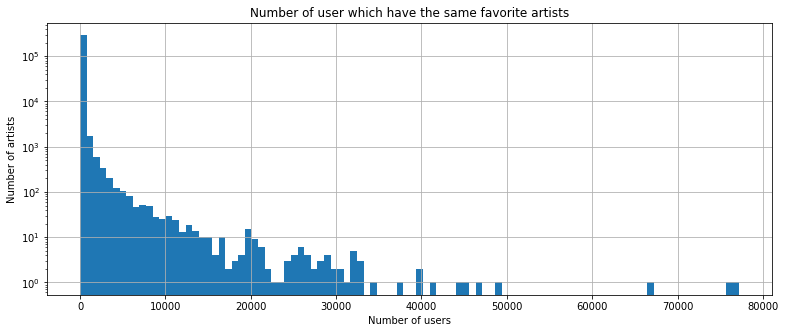

In [24]:
top_data.groupby('Artist').count()['ID'].reset_index().hist(bins = 100, figsize = (13, 5))
plt.yscale('log')
plt.title('Number of user which have the same favorite artists')
plt.xlabel('Number of users')
plt.ylabel('Number of artists')

We see that most artist have very few users in common, but the fact that quite some artists have more than 10000 users listening to them seems promising.